# Guide to Generating Human-level Text with Contrastive Search in Transformers

This is a companion notebook to the [Hugging Face guest blog post entry about contrastive search](https://huggingface.co/blog/introducing-csearch)

*   What is natural language generation?
*   What is Contrastive Search and how does it work?


Natural language generation is the process of creating written or spoken language using a computer program. It is an important task in natural language processing (NLP), which involves using computers to understand, interpret, and generate human language.
Contrastive Search is a new decoding method for neural text generation that was proposed in the research paper "[A Contrastive Framework for Neural Text Generation](https://arxiv.org/abs/2202.06417)" and further developed in "[Contrastive Search Is What You Need For Neural Text Generation](http://arxiv.org/abs/2210.14140)." It has been shown to be able to generate human-level text using off-the-shelf language models across 16 different languages.
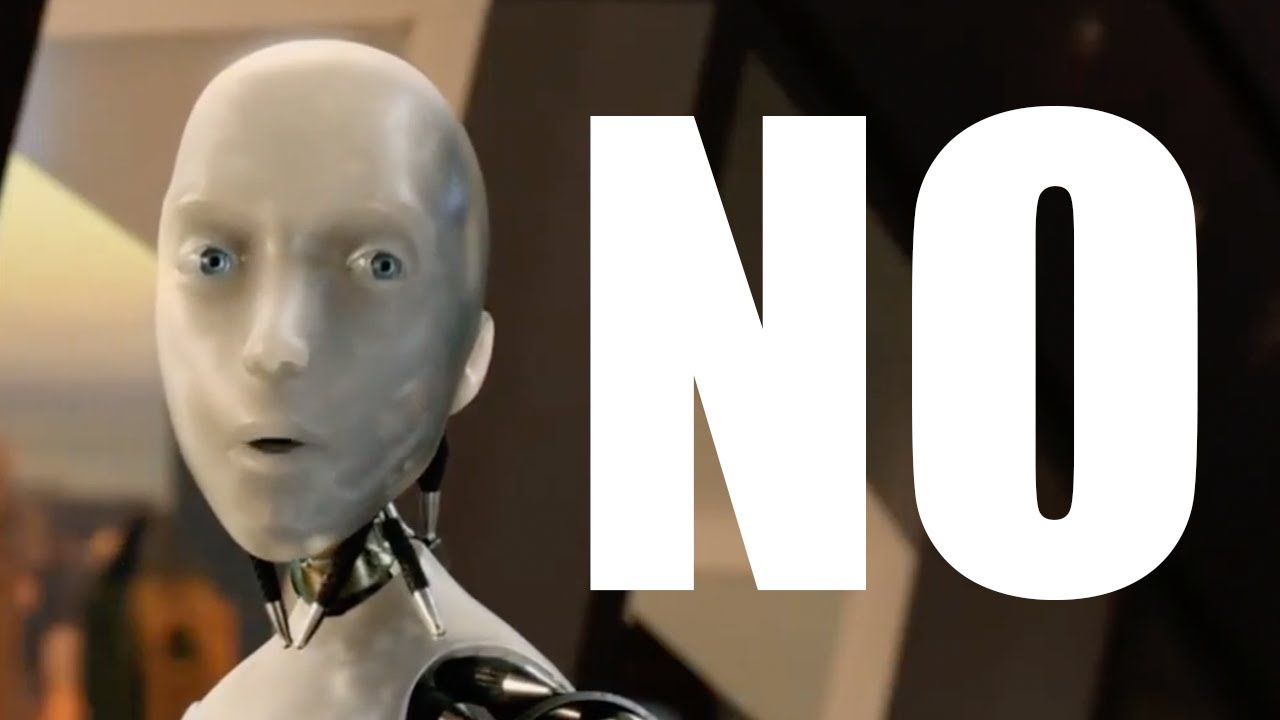







# Deeper into NLP

* Why study NLP?
* What is the history of NLP?
* What are some applications used daily with NLP?


NLP(Natural Language Processing) is connected with computer science, artifical intelligence, and Human Language processing. NLP can be used for spell checking, spam detection, and sentiment analysis applications, there is also translations, automatic summarization, and chat bots!

1950, Alan Turing, Turing test is created.
1954, Georgetown-IBM, First machine translator.
1966, Eliza, First Chatbot.
1993, Simon, First smartphone


# Contrastive Search

### Demonstration of Contrastive Search:
*   Where can I try out Contrastive Search for myself?

You can try out Contrastive Search for yourself using Hugging Face's transformers library, which is available in both PyTorch and TensorFlow. There is a demo available that compares Contrastive Search with other popular decoding methods, and you can also use [this collab notebook](https://huggingface.co/spaces/joaogante/contrastive_search_generation) to interact with the examples mentioned here.

We have added the same tutorial for PyTorch and TensorFlow -- feel free to pick your framework of choice! 🤗

# PyTorch Tutorial:

## 1. Environment Installation:

*   How do I install the necessary tools for running the following experiments?

In order to run the experiments described in the following sections, you will need to install the update-to-date version of the transformers library. This can be done by running the following commands:

In [ ]:
! pip install torch
! pip install "transformers>=4.24.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 11.8 MB/s 
     |████████████████████████████████| 7.6 MB 61.2 MB/s 
     |████████████████████████████████| 182 kB 88.1 MB/s 


## 2. Problems of Existing Decoding Methods:

*   What are deterministic methods and what are their drawbacks?
*   What are stochastic methods and what are their drawbacks?






Decoding methods for text generation can be divided into two categories:



### 1. Deterministic methods

Deterministic methods, such as greedy search and beam search, generate text by selecting the text continuation with the highest likelihood as determined by the language model. However, these methods often result in unnatural and repetitive text.

###2.  Stochastic methods

Stochastic methods, such as top-k sampling and nucleus sampling, introduce randomness during the decoding process in an attempt to avoid model degeneration. However, these methods can still produce repetitive and incoherent text.


### 2.1. Determinstic Methods:



In [ ]:
import torch
from transformers import AutoTokenizer, GPT2LMHeadModel
tokenizer = AutoTokenizer.from_pretrained('gpt2-large')
input_ids = tokenizer('DeepMind Company is', return_tensors='pt').input_ids
model = GPT2LMHeadModel.from_pretrained('gpt2-large')

output = model.generate(input_ids, max_length=128)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
DeepMind Company is a leading AI research company, with a focus on deep learning and deep learning-based systems.

The company's research is focused on the development of deep learning-based systems that can learn from large amounts of data, and that can be used to solve real-world problems.

DeepMind's research is also used by the UK government to develop new technologies for the UK's National Health Service.

DeepMind's research is also used by the UK government to develop new technologies for the UK's National Health Service.

DeepMind's research is also used by the UK government to develop new technologies
----------------------------------------------------------------------------------------------------


As we can see by the output deterministic methods are prone to repeating themselves. This is due to their greedy nature. That is, they only pick the tokens (words) that have the highest likelihood of occuring. 

### 2.2. Stochastic Methods:

In [ ]:
import torch
from transformers import AutoTokenizer, GPT2LMHeadModel
tokenizer = AutoTokenizer.from_pretrained('gpt2-large')
input_ids = tokenizer('DeepMind Company is', return_tensors='pt').input_ids
model = GPT2LMHeadModel.from_pretrained('gpt2-large')

torch.manual_seed(0.)
output = model.generate(input_ids, do_sample=True, max_length=128, top_p=0.95, top_k=0)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
DeepMind Company is a leading provider of AI-based research, development, and delivery of AI solutions for security, infrastructure, machine learning, communications, and so on."

'AI is not journalism'

Worse still was the message its researchers hoped would reach the world's media — that it was not really research, but rather a get-rich-quick scheme to profit from living forces' ignorance.

"The thing is, we know that people don't consciously assess the value of the others' information. They understand they will get the same on their own."

One example? Given the details of today
----------------------------------------------------------------------------------------------------


From our stochastic methods we can see a clear improvement in regards to the the repitiveness. However, we see that there is a noticeable decrease in the coherency of the model. This can be explained by the stochastic nature of the algorithm. First, top-k sampling is a stochastic method which picks the top k number of words and randomly selects from that set of words. Top-p sampling (aka nucleus sampling) picks a set of words that cross a probability threshold and randomly chooses a word from that set. These two decoding methods clearly avoid repitition but struggle to maintain coherency and context. 

## 3. Contrastive Search: A New Decoding Method
*   How does Contrastive Search address the problems of existing decoding methods?
*   How does Contrastive Search work?

Contrastive Search addresses the problems of existing decoding methods by using a contrastive loss function to guide the decoding process. This loss function measures the similarity between the generated text and a set of reference texts and encourages the generation of text that is similar to the references while also being diverse.
The Contrastive Search decoding process involves the following steps: (1) encoding the reference texts using a language model, (2) generating initial text using a language model and a randomly-initialized decoder, (3) iteratively refining the generated text by minimizing the contrastive loss function using gradient descent.


## In-depth Explanation: Contrastive Loss Function

Now, if you are not particularly keen on looking at math over your break, no worries! Please skip to section 3.1. If you enjoy the knitty gritty details and want to understand what makes contrastive search so powerful then this next section is for you.

As stated earlier, contrastive search is the best of both worlds. Contrastive search maintains the level of coherency that deterministic methods have while also keeping the text rich and diverse similar to the stochastic methods. And the way it does so is through the use of the contrastive loss function.

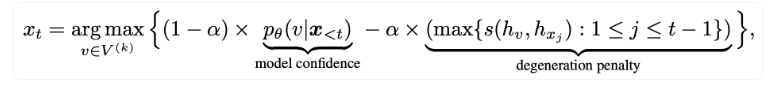

This might seem like too much to unpack but stick with me. First, let's understand what each term is

- $x_t$ is our output token
-$ v \in V^{(k)}$ These are our top $k$  predictions from our LLM probability distribution $p_\theta(v|x_{<t})$
- $p_\theta(v|x_{<t})$ this is our probability distribution. This is our model confidence which basically says "what is the probability of $v$ given our input prefix text $x_{<t}$. 
- $max(\{s(h_v, h_{x_j}) : 1 \leq j \leq t -1\})$ is our degeneration penalty. $s(h_v, h_{x_j})$ is the cosine similarity score between v and all of the other tokens in our prefix text. Meaning that our entire degeneration penalty takes the word with the highest similarity to the other tokens. 
- $\alpha$ - this constant mediates the importance between model confidence and degeneration penalty. If $\alpha$ goes to zero then our degeneration penalty is zero and we are only picking the word v that gives us the highest probability. Sound familiar? When alpha goes to zero we have a basic greedy (deterministic) search
- In short, our contrastive loss function wants to find the word $v$ that has the highest probability of occuring but also the least resemblance to words that already exist in our prefix text (i.e) have low degeneration penalty.  


### 3.1. Generating Text with Contrastive Search:

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
model_name = 'gpt2-large'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)
model.eval()

# prepare the prefix
prefix_text = r'DeepMind Company is'
inputs = tokenizer(prefix_text, return_tensors='pt').input_ids

# generate the result with contrastive search
output = model.generate(input_ids, penalty_alpha=0.6, top_k=4, max_length=512)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

Output:
----------------------------------------------------------------------------------------------------
DeepMind Company is a leader in artificial intelligence (AI). We have a long history of working with companies such as Google, Facebook, Amazon, and Microsoft to build products that improve people's lives, and today we are excited to announce that DeepMind's AlphaGo program has won the game of Go, becoming the first program to defeat a professional Go player.

The victory is a testament to the power of deep learning, and to the incredible work of our research team, which has been at the forefront of AI research for the past five years. AlphaGo is one of the most advanced Go programs ever created, and its performance is an important step towards the goal of human-level AI.

"This is the culmination of a decade of hard work," said Andy Ng, co-founder and CTO of DeepMind. "We are thrilled to have achieved this milestone and look forward to continuing to develop AI that can be used 

As you can see, using contrastive search nets us a result that is neither repetitive or grammatically incoherent. Out of the three decoding methods we have explained this method has the closest resemblance to what a human would write.

## 4. More Generated Examples:

### 4.1. Example One - GPT-2:

In [ ]:
# Load the language model and prepare the prefix text:
import torch
from transformers import AutoTokenizer, GPT2LMHeadModel
tokenizer = AutoTokenizer.from_pretrained('gpt2-large')
model = GPT2LMHeadModel.from_pretrained('gpt2-large')
prefix_text = r"In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English."
input_ids = tokenizer(prefix_text, return_tensors='pt').input_ids

#### 4.1.1. Generating Text with Greedy Search:

In [ ]:
output = model.generate(input_ids, max_length=512)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The researchers, led by Dr. David R. Williams of the University of California, Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is known for its unique geology and is home to a number of rare species of animals.

The researchers found the unicorns in the Andes Mountains of Peru.

"We were surprised to find that the unicorns were able to communicate with each other," Williams said. "We were also surprised to find that they were able to communicate in English."

The researchers believe that the unicorns are descendants of the ancient Incas, who lived in the area around 2,000 years ago.

"The Incas were the first people to use

#### 4.1.2. Generating Text with Nucleus Sampling:

In [ ]:
torch.manual_seed(0.)
output = model.generate(input_ids, do_sample=True, max_length=512, top_p=0.95, top_k=0)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. The study was published in the Journal of Zoology in March 2016.

Polygynous mammals such as unicorns have remained largely unknown to science. Professor Gustavo Giacota, from the University of Oxford who led the study, said that they had been documented as far as Eastern Siberia in Russia, but had only been seen a handful of times in the Gobi Desert.

Tiny animals with pale and shiny coats live in the presence of human beings and are hardly likely to be victims of any cruelty. However, there is some evidence of the condition occurring in both humans and animals in remote regions, which might have similarities to "black moles" that coexist on the skin.

#### 4.1.3. Generating Text with Contrastive Search:

In [ ]:
output = model.generate(input_ids, max_length=512, penalty_alpha=0.6, top_k=4)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

According to the BBC, a team of scientists led by Dr David MacKay, from the University of Bristol, spent two years searching for the unicorn herd, which they discovered during a survey of the area.

"It's a very rare find," MacKay told the BBC. "There are a few in the Himalayas, but this is the first time we've been able to find one in such a remote area."

The team was surprised to find a herd of unicorns living in a region that has been known to be a hotbed of poaching, with many of the animals poached for their horns, which are used in traditional Chinese medicine to treat everything from rheumatism to cancer.

"We knew that the area was rich in rh

### 4.2. Example Two - OPT:

In [ ]:
# Load the language model and prepare the prefix text:
import torch
from transformers import AutoTokenizer, OPTForCausalLM
model_name = r'facebook/opt-1.3b'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = OPTForCausalLM.from_pretrained(model_name)

prefix_text = r"Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously."
input_ids = tokenizer(prefix_text, return_tensors='pt').input_ids

#### 4.2.1. Generating Text with Greedy Search:

In [ ]:
output = model.generate(input_ids, max_length=256)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

Output:
----------------------------------------------------------------------------------------------------
Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. We show that the residual learning framework can be used to train deep neural networks that are significantly more difficult to train than those used previously. We also show that the residual learning framework can be used to train deep neural networks that are significantly more difficult to train than those used previously.

The paper presents a new residual learning framework for deep neural networks that is based on the concept of residuals. The residuals are the residuals of the network that are not used in the training process. The residuals are computed by taking the residuals of the network that are used in the training process and subtracting the residuals of the network that are not used

#### 4.2.2. Generating Text with Nucleus Sampling:

In [ ]:
torch.manual_seed(0.)
output = model.generate(input_ids, do_sample=True, max_length=256, top_p=0.95, top_k=0)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

Output:
----------------------------------------------------------------------------------------------------
Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. The theory focuses on several aspects of learning, including the dynamics of replicative and non-replicative aspects of learning. This framework emphasizes learning by entropy. New randomized algorithms enable training networks with residual learning, so that deep networks can be deployed as reliably and as efficiently as their more conventional counterparts.
----------------------------------------------------------------------------------------------------


#### 4.2.3. Generating Text with Contrastive Search:

In [ ]:
output = model.generate(input_ids, max_length=256, penalty_alpha=0.6, top_k=6)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

Output:
----------------------------------------------------------------------------------------------------
Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.

In this paper, we propose a model-based residual learning (MBRL) framework that is based on neural networks trained on data that is sparse in terms of dimensionality (e.g., 1, 2, 3, etc.). The network parameters are chosen such that there is a high probability of convergence, i.e., the number of iterations is large enough to minimize the variance of the residuals. This is achieved by training the network on a set of training data, in which the data is sparse in terms of dimensionality, and then discarding the nonparametric part of the data after training is complete.

We show that MBRL outperforms other methods for deep reinforcement learning (RL) and deep convolutional neural networks (CNNs) by a

# TensorFlow

⚠️ The TensorFlow version of Contrastive Search is not yet released -- it will be part of v4.25. Until then, if you install the dev version, you can have access to it. 

To make it up for this inconvinience on the TF front, we're delighted to announce that Contrastive Search is XLA-compatible, meaning that you can compile your generation call to XLA to get significant speed ups 🔥 See our [TF XLA Generation blog post](https://huggingface.co/blog/tf-xla-generate) for more information.

## 1. Environment Installation:

In [ ]:
! pip install tensorflow
# Constrastive Search for TensorFlow will be released in v4.25.0. Meanwhile, you can install the dev version:
# ! pip install "transformers>=4.25.0"
! pip install git+https://github.com/huggingface/transformers.git

## 2. Problems of Existing Decoding Methods:

### 2.1. Deteriminstic Methods:

In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2LMHeadModel
tokenizer = AutoTokenizer.from_pretrained('gpt2-large')
input_ids = tokenizer('DeepMind Company is', return_tensors='tf').input_ids
model = TFGPT2LMHeadModel.from_pretrained('gpt2-large')

output = model.generate(input_ids, max_length=128)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Output:
----------------------------------------------------------------------------------------------------
DeepMind Company is a leading AI research company, with a focus on deep learning and deep learning-based systems.

The company's research is focused on the development of deep learning-based systems that can learn from large amounts of data, and that can be used to solve real-world problems.

DeepMind's research is also used by the UK government to develop new technologies for the UK's National Health Service.

DeepMind's research is also used by the UK government to develop new technologies for the UK's National Health Service.

DeepMind's research is also used by the UK government to develop new technologies
----------------------------------------------------------------------------------------------------


### 2.2. Stochastic Methods:

In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2LMHeadModel
tokenizer = AutoTokenizer.from_pretrained('gpt2-large')
input_ids = tokenizer('DeepMind Company is', return_tensors='tf').input_ids
model = TFGPT2LMHeadModel.from_pretrained('gpt2-large')

tf.random.set_seed(0)
output = model.generate(input_ids, do_sample=True, max_length=128, top_p=0.95, top_k=0)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Output:
----------------------------------------------------------------------------------------------------
DeepMind Company is the Google on Earth platform, a communication platform designed to improve the tools humanity can use to get an understanding of the human brain.

In May it released AlphaGo, a artificial intelligence program that defeated the world chess champion last month at the Go Global Chess Championship.

With AlphaGo's victory, three others defeated top players, including two of the World Go champions, at the world championship.

"Neural networks are a next-generation generative neural network model of human thought and cognition," Ma said. "When using neural networks, one cannot just rely on a few hundred training examples as this
----------------------------------------------------------------------------------------------------


## 3. Contrastive Search:

### 3.1. Generating Text with Contrastive Search:

In [ ]:
import tensorflow
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
model_name = 'gpt2-large'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = TFGPT2LMHeadModel.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)

# prepare the prefix
prefix_text = r'DeepMind Company is'
inputs = tokenizer(prefix_text, return_tensors='tf').input_ids

# generate the result with contrastive search
output = model.generate(input_ids, penalty_alpha=0.6, top_k=4, max_length=512)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Output:
----------------------------------------------------------------------------------------------------
DeepMind Company is a leader in artificial intelligence (AI). We have a long history of working with companies such as Google, Facebook, Amazon, and Microsoft to build products that improve people's lives, and today we are excited to announce that DeepMind's AlphaGo program has won the game of Go, becoming the first program to defeat a professional Go player.

The victory is a testament to the power of deep learning, and to the incredible work of our research team, which has been at the forefront of AI research for the past five years. AlphaGo is one of the most advanced Go programs ever created, and its performance is an important step towards the goal of human-level AI.

"This is the culmination of a decade of hard work," said Andy Ng, co-founder and CTO of DeepMind. "We are thrilled to have achieved this milestone and look forward to continuing to develop AI that can be used 

## 4. More Generated Examples:

### 4.1. Example One - GPT-2:

In [ ]:
# Load the language model and prepare the prefix text:
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2LMHeadModel
tokenizer = AutoTokenizer.from_pretrained('gpt2-large')
model = TFGPT2LMHeadModel.from_pretrained('gpt2-large')
prefix_text = r"In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English."
input_ids = tokenizer(prefix_text, return_tensors='tf').input_ids

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


#### 4.1.1. Generating Text with Greedy Search:

In [ ]:
output = model.generate(input_ids, max_length=512)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Output:
----------------------------------------------------------------------------------------------------
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The researchers, led by Dr. David R. Williams of the University of California, Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is known for its unique geology and is home to a number of rare species of animals.

The researchers found the unicorns in the Andes Mountains of Peru.

"We were surprised to find that the unicorns were able to communicate with each other," Williams said. "We were also surprised to find that they were able to communicate in English."

The researchers believe that the unicorns are descendants of the ancient Incas, who lived in the area around 2,000 years ago.

"The Incas were the first people to use

#### 4.1.2. Generating Text with Nucleus Sampling:

In [ ]:
tf.random.set_seed(0)
output = model.generate(input_ids, do_sample=True, max_length=512, top_p=0.95, top_k=0)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Output:
----------------------------------------------------------------------------------------------------
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The findings of the study, published in the journal Current Biology, are a result of an attempt to track down the pinniped unicorns by placing itself in the head of a Ramaolin Indian bear bear, in order to tease out information about their behavior. The aim of the study was to calculate the levels of fertility, which is some of the most mysterious phenomena in nature, says Prof. Alfredo Marino, not only about unicorns but also about human life.

The study happened in 2000, when Marino was conducting a Ph.D. thesis on the genetics of the tribe.

Confronted with a very huge body of results by this research, Marino, to this day, knows nothing about them.

#### 4.1.3. Generating Text with Contrastive Search:

In [ ]:
output = model.generate(input_ids, max_length=512, penalty_alpha=0.6, top_k=4)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Output:
----------------------------------------------------------------------------------------------------
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

According to the BBC, a team of scientists led by Dr David MacKay, from the University of Bristol, spent two years searching for the unicorn herd, which they discovered during a survey of the area.

"It's a very rare find," MacKay told the BBC. "There are a few in the Himalayas, but this is the first time we've been able to find one in such a remote area."

The team was surprised to find a herd of unicorns living in a region that has been known to be a hotbed of poaching, with many of the animals poached for their horns, which are used in traditional Chinese medicine to treat everything from rheumatism to cancer.

"We knew that the area was rich in rh

### 4.2. Example Two - OPT:

In [ ]:
# Load the language model and prepare the prefix text:
import tensorflow as tf
from transformers import AutoTokenizer, TFOPTForCausalLM
model_name = r'facebook/opt-1.3b'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFOPTForCausalLM.from_pretrained(model_name)

prefix_text = r"Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously."
input_ids = tokenizer(prefix_text, return_tensors='tf').input_ids

All model checkpoint layers were used when initializing TFOPTForCausalLM.

All the layers of TFOPTForCausalLM were initialized from the model checkpoint at facebook/opt-1.3b.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOPTForCausalLM for predictions without further training.


#### 4.2.1. Generating Text with Greedy Search:

In [ ]:
output = model.generate(input_ids, max_length=256)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

Output:
----------------------------------------------------------------------------------------------------
Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. We show that the residual learning framework can be used to train deep neural networks that are significantly more difficult to train than those used previously. We also show that the residual learning framework can be used to train deep neural networks that are significantly more difficult to train than those used previously.

The paper presents a new residual learning framework for deep neural networks that is based on the concept of residuals. The residuals are the residuals of the network that are not used in the training process. The residuals are computed by taking the residuals of the network that are used in the training process and subtracting the residuals of the network that are not used

#### 4.2.2. Generating Text with Nucleus Sampling:

In [ ]:
tf.random.set_seed(0)
output = model.generate(input_ids, do_sample=True, max_length=256, top_p=0.95, top_k=0)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

Output:
----------------------------------------------------------------------------------------------------
Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. Experimental results show that our method does in fact achieve deep networks with a lower training time and less error.

Although there are numerous cross-validation methods available to improve the reproducibility of one-shot experiments with no sample replication, the underlying mechanism behind these methods is usually poorly understood. In this paper we report an agglutinin-like cell sorting (ASYSC) method that achieves significant pooled and reproducible results for phage display experiments with a distinctive comparative advantage.

Overall, visual recall performance was unchanged in young children over 10 years, when the model is first trained. Here, we show how teaching technology and reten

#### 4.2.3. Generating Text with Contrastive Search:

In [ ]:
output = model.generate(input_ids, max_length=256, penalty_alpha=0.6, top_k=6)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

Output:
----------------------------------------------------------------------------------------------------
Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.

In this paper, we propose a model-based residual learning (MBRL) framework that is based on neural networks trained on data that is sparse in terms of dimensionality (e.g., 1, 2, 3, etc.). The network parameters are chosen such that there is a high probability of convergence, i.e., the number of iterations is large enough to minimize the variance of the residuals. This is achieved by training the network on a set of training data, in which the data is sparse in terms of dimensionality, and then discarding the nonparametric part of the data after training is complete.

We show that MBRL outperforms other methods for deep reinforcement learning (RL) and deep convolutional neural networks (CNNs) by a

## Experiments and Results:
*   What experiments were conducted to test the effectiveness of Contrastive Search?
*   What were the results of these experiments?

The effectiveness of Contrastive Search was tested using a variety of language models and datasets in multiple languages.
The results of these experiments showed that Contrastive Search consistently outperformed other decoding methods in terms of both the naturalness and diversity of the generated text.


## Conclusion:
*   What are the key takeaways from this research?
*   What are the future implications of this work?

Contrastive Search is a promising new decoding method for neural text generation that is able to generate human-level text across multiple languages.
Future work could involve exploring the potential applications of Contrastive Search in other NLP tasks, such as machine translation and summarization.


# GPT2 + Gradio Implementation


## 1. GPT2


### 1.1. Model

We will be using the Transformers library to call the GPT2 model. Transformers which is built on top the PyTorch library, provides a set of pre-trained transformer models that are easy to use and fine-tune for a variety of natural language processing tasks.

The library includes several state-of-the-art transformer models including BERT (Bidirectional Encoder Representations from Transformers), GPT (Generative Pre-training Transformer), and RoBERTa (Robustly Optimized BERT Pretraining Approach).

#### 1.1.2 Tokenization

In natural language processing (NLP), tokenization is often used to preprocess text data so that it can be more easily analyzed or processed by other software. For example, a tokenizer might be used to extract individual words from a document, or to identify and separate out punctuation and other special characters.

In [ ]:
import transformers

# Load the GPT-2 tokenizer
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")

text = "The quick brown fox jumps over the lazy dog."

# Tokenize the text
tokens = tokenizer.tokenize(text)
print(tokens)


Output:

['The', 'Ġquick', 'Ġbrown', 'Ġfox', 'Ġjumps', 'Ġover', 'Ġthe', 'Ġlazy', 'Ġdog', '.']

GPT2Tokenizer is using a technique called byte-pair encoding (BPE) to split the text into subwords. BPE is a subword tokenization technique that aims to reduce the size of the vocabulary by replacing frequently occurring word pieces (e.g. "qu", "ick") with a single token. This can be useful for handling rare or out-of-vocabulary words, and can also improve the performance of language models by reducing the number of unique tokens that need to be processed.

In the output, the Ġ characters indicate the start of a subword token. For example, the token "Ġquick" is made up of the subwords "qu" and "ick", which have been joined together using BPE.

## 2. Gradio

Gradio is an open-source library that allows you to easily create and deploy interactive web-based interfaces for machine learning models. With Gradio, you can wrap your model in a user-friendly interface and share it with others, allowing them to test the model and provide feedback without needing to know how to write code.

In [ ]:
! pip install gradio

Here is an example of how to use Gradio to create an interface in Python:

In [ ]:
import gradio as gr

def contrastive_search(input):
    
    return "Hello " + input + "!"

demo = gr.Interface(fn=contrastive_search, inputs="text", outputs="text")

demo.launch(debug=True)  

## 3. Combining GPT2 and Gradio

First the model is loaded using the respective tokenizer

In [ ]:
import gradio as gr
from transformers import GPT2Tokenizer, GPT2LMHeadModel

model_name = 'gpt2-large'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)
model.eval() 

ModuleNotFoundError: ignored

Then we create the Gradio Interface to interact with the GPT2 model based on user input

In [ ]:
def contrastive_search(input):

  prefix_text = raw_string = r"{}".format(input) #convert string to raw string
  
  #tokenize the words set return_tensors to 'pt' and retrieve the input_ids (1 line)
  input_ids = tokenizer(prefix_text, return_tensors='pt').input_ids 
  
  # generate word embeddings from the input_ids. Set penalty_alpha=0.6, top_k=4, and max_length=64 (1 line)
  model_output = model.generate(input_ids, penalty_alpha=0.6, top_k=4, max_length=64) 
  
  # use the tokenizer decode method and turn our output from model_output into text. Set skip_special_tokens=True (1 line)
  gradio_output = tokenizer.decode(model_output[0], skip_special_tokens=True) 

  separator = '.'
  result = gradio_output.rsplit(separator, 1)[0] + separator
  return result

# use the gradio interface method to build you interactive site. Set fn to contrastive search and inputs and outputs to 'text' (1 line)
demo = gr.Interface(fn=contrastive_search, inputs="text", outputs="text")

# launch your demo. Set debug and share to True (1 line). You're done!
demo.launch(debug=True, share=True) 

## References
- "A Contrastive Framework for Neural Text Generation" 
- add citation 
Add citation for the hugging face website